<h1 align="center">
Разработка модели машинного обучения для интернет-магазина<br>
«В один клик»
</h1>

<br>

Мы получили набор данных от интернет-магазина:
- данные о покупателях: `id`, `Покупательская активность`, `Тип сервиса`, `Акционные покупки` и др.
- данные о выручке с пользователя: `id`, `Период`, `Выручка`.
- данные о прибыли с пользователя: `id`, `Прибыль`.
- данные о времени пользователя на сайте: `id`, `Период`, `Минут`.

<b>Цели исследования:</b>
1. Определить факторы, влияющие на снижение покупательской активности пользователей.
2. Разработать рекомендации по удержанию клиентов на основе модели машинного обучения.

<b>Ход исследования:</b>
1. Изучить данные из датасетов `market_file.csv`, `market_money.csv`, `market_time.csv`, `money.csv`.
2. Провести исследовательский и корреляционный анализ.
3. Обучить 4 модели с использованием пайплайнов, выбрать лучшую.
4. Провести анализ важности признаков модели.
5. Сегментировать пользователей интернет-магазина.
6. Решить задачи бизнеса: разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Загрузка данных

In [1]:
!pip install shap --quiet
!pip install phik --quiet
!pip install -U scikit-learn --quiet

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import shap
from sklearn.utils import resample
from phik import resources, report
from phik.report import plot_correlation_matrix
import math

In [3]:
pth = './market_file.csv'

if os.path.exists(pth):
    data_market = pd.read_csv('market_file.csv')
    data_market_revenue = pd.read_csv('market_money.csv')
    data_market_time = pd.read_csv('market_time.csv')
    data_market_income = pd.read_csv('money.csv', sep=';')
else:
    data_market = pd.read_csv('/datasets/market_file.csv')
    data_market_revenue = pd.read_csv('/datasets/market_money.csv')
    data_market_time = pd.read_csv('/datasets/market_time.csv')
    data_market_income = pd.read_csv('/datasets/money.csv', sep=';')

In [4]:
#смотрим на data_market
data_market.sample(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
383,215731,Снизилась,стандарт,да,3.5,4,800,0.22,Домашний текстиль,4,5,2,4
1122,216470,Прежний уровень,стандарт,да,4.3,5,522,0.30,Товары для детей,5,3,8,11
832,216180,Прежний уровень,премиум,нет,6.6,4,887,0.25,Мелкая бытовая техника и электроника,5,3,4,13
741,216089,Прежний уровень,стандарт,нет,4.6,4,561,0.20,Товары для детей,4,3,1,14
1022,216370,Прежний уровень,стандарт,нет,5.2,4,717,0.13,Кухонная посуда,2,3,5,9


In [5]:
data_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [6]:
#смотрим на data_market_revenue
data_market_revenue.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [7]:
data_market_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [8]:
data_market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [9]:
data_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [10]:
#смотрим на data_market_income
data_market_income.sample(5)

,id,Прибыль
609,215957,"5,95"
804,216152,"3,91"
1077,216425,"4,15"
704,216052,"3,5"
114,215462,"3,13"


In [11]:
data_market_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


**Промежуточный вывод:** для анализа мы получили 4 датафрейма с данными о пользователях интернет-магазина, их поведении и тратах. Пропуски отсутствуют, видим ошибку в типе данных `data_market_income['прибыль']`.

##  Предобработка данных

In [12]:
#изменим тип данных в data_market_income
data_market_income['Прибыль'] = (data_market_income['Прибыль'].str.replace(',', '.', regex=False).astype(float))

In [13]:
#приведем названия столбцов к правильному виду

df_all = {
    "data_market": data_market,
    "data_market_revenue": data_market_revenue,
    "data_market_time": data_market_time,
    "data_market_income": data_market_income
}

for name, df in df_all.items():
    df.columns = (
        df.columns
        .str.lower()
        .str.replace(' ', '_')
        .str.replace(',', '_')
        .str.replace('__', '_')
    )

In [14]:
#приведем значения категоральных столбцов к правильному виду

for name, df in df_all.items():
    for col in df.select_dtypes(include="object").columns:
        df[col] = (
            df[col]
            .astype(str)      # - на случай, если есть NaN
            .str.strip()      # - убрать пробелы по краям
            .str.lower()
            .str.replace(' ', '_')
            .str.replace(',', '_')
            .str.replace('__', '_')
        )

In [15]:
data_market.sample(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
501,215849,прежний_уровень,стандарт,да,4.9,4,399,0.25,товары_для_детей,4,3,3,5
820,216168,прежний_уровень,стандарт,да,5.5,4,577,0.17,товары_для_детей,4,4,4,16
918,216266,прежний_уровень,премиум,нет,3.2,3,337,0.17,кухонная_посуда,3,1,3,8
371,215719,снизилась,премиум,да,2.4,5,460,0.22,косметика_и_аксесуары,1,6,8,4
19,215367,снизилась,премиум,да,4.2,4,581,0.40,товары_для_детей,5,1,4,1


In [16]:
#видим неявный дубликат в 'тип_сервиса'
data_market['тип_сервиса'].value_counts()

стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64

In [17]:
#видим опечатку
data_market_time['период'].value_counts()

текущий_месяц       1300
предыдцщий_месяц    1300
Name: период, dtype: int64

In [18]:
#удаляем дубликат, исправляем опечатку
data_market['тип_сервиса'] = data_market['тип_сервиса'].replace({"стандартт": "стандарт"})
data_market_time['период'] = data_market_time['период'].replace({"предыдцщий_месяц": "предыдущий_месяц"})

In [19]:
#проверяем датасеты на дубликаты id пользователей
for name, df in df_all.items():
    print(f'Дубликатов id в {name}: {df["id"].duplicated().sum()}')

Дубликатов id в data_market: 0
Дубликатов id в data_market_revenue: 2600
Дубликатов id в data_market_time: 1300
Дубликатов id в data_market_income: 0


In [20]:
#проверяем датасеты на пропуски
for name, df in df_all.items():
    print(f'Пропусков в {name}: {df.isna().sum().sum()}')

Пропусков в data_market: 0
Пропусков в data_market_revenue: 0
Пропусков в data_market_time: 0
Пропусков в data_market_income: 0


In [21]:
#проверяем датасеты на дубликаты строк
for name, df in df_all.items():
    print(f'Дубликатов строк в {name}: {df.duplicated().sum()}')

Дубликатов строк в data_market: 0
Дубликатов строк в data_market_revenue: 0
Дубликатов строк в data_market_time: 0
Дубликатов строк в data_market_income: 0


**Промежуточный вывод:** исправили ошибку в типе данных `data_market_income['прибыль']`, привели названия столбцов и значения к стандартам оформления, проверили на пропуски и дубликаты.

##  Исследовательский анализ данных

In [22]:
print('Уникальных значений в "маркет_актив_тек_мес"', data_market['маркет_актив_тек_мес'].nunique())
print('Уникальных значений в "маркет_актив_6_мес"', data_market['маркет_актив_6_мес'].nunique())

Уникальных значений в "маркет_актив_тек_мес" 3
Уникальных значений в "маркет_актив_6_мес" 41


In [23]:
#округлим значения в `маркет_актив_6_мес`, чтобы он стал дискретным
data_market['маркет_актив_6_мес'] = data_market['маркет_актив_6_мес'].round().astype(int)

In [24]:
sorted(data_market['маркет_актив_6_мес'].value_counts().index)

[1, 2, 3, 4, 5, 6, 7]

In [25]:
# функция для построения графиков
def df_plot(
    df, 
    ncols=2, 
    base_height=4, 
    base_width=6, 
    col=None, 
    boxplot=None,
    exclude=None,
    discrete=None
):
    """
    - col=None - строим все графики, либо для 1 колонки
    - boxplot=[...] - для каких признаков строить boxplot
    - exclude=[...] - исключаемые колонки
    - discrete=[...] - дискретные числовые признаки (countplot)
    """

    if exclude is None:
        exclude = []
    if boxplot is None:
        boxplot = []
    if discrete is None:
        discrete = []

    # фильтруем колонки
    cat_cols = [c for c in df.select_dtypes(include=['object', 'category']).columns if c not in exclude]
    num_cols = [c for c in df.select_dtypes(include=['number']).columns if c not in exclude]

    # разделяем на дискретные и непрерывные
    num_discrete = [c for c in discrete if c in num_cols]
    num_continuous = [c for c in num_cols if c not in num_discrete]

    # ======= режим "одна колонка" =======
    if col is not None:
        if col in cat_cols:
            fig, ax = plt.subplots(figsize=(6, 4))
            df[col].value_counts().plot(kind='bar', ax=ax)
            ax.set_title(f"Распределение {col}")
            ax.set_xlabel(col)
            ax.set_ylabel("Количество")
            ax.tick_params(axis='x', rotation=45)
            plt.show()

        elif col in num_continuous:
            fig, axes = plt.subplots(1, 2 if col in boxplot else 1, figsize=(10, 4))
            if not isinstance(axes, (list, np.ndarray)):
                axes = [axes]

            # гистограмма
            df[col].hist(ax=axes[0], bins=30)
            axes[0].set_title(f"Гистограмма {col}")
            axes[0].set_xlabel(col)
            axes[0].set_ylabel("Количество")

            # boxplot (только если col в списке)
            if col in boxplot and len(axes) > 1:
                sns.boxplot(y=df[col], ax=axes[1])
                axes[1].set_title(f"Boxplot {col}")
                axes[1].set_ylabel(col)
                axes[1].set_xlabel("")

            plt.tight_layout()
            plt.show()

        elif col in num_discrete:
            fig, ax = plt.subplots(figsize=(6, 4))
            sns.countplot(x=col, data=df, ax=ax)
            ax.set_title(f"Countplot {col}")
            ax.set_xlabel(col)
            ax.set_ylabel("Количество")
            ax.tick_params(axis='x', rotation=45)
            plt.show()
        return

    # ======= режим "все колонки" =======

    # 1. Категориальные
    if len(cat_cols) > 0:
        total_plots = len(cat_cols)
        nrows = (total_plots + ncols - 1) // ncols
        figsize = (ncols * base_width, nrows * base_height)

        fig, axes = plt.subplots(nrows, ncols, figsize=figsize, constrained_layout=True)
        axes = axes.flatten()

        for i, c in enumerate(cat_cols):
            df[c].value_counts().plot(kind='bar', ax=axes[i])
            axes[i].set_title(f"Распределение {c}")
            axes[i].set_xlabel(c)
            axes[i].set_ylabel("Количество")
            axes[i].tick_params(axis='x', rotation=45)

        for ax in axes[len(cat_cols):]:
            ax.axis("off")

        plt.show()

    # 2. Числовые непрерывные
    if len(num_continuous) > 0:
        total_plots = len(num_continuous) + len([c for c in num_continuous if c in boxplot])
        nrows = (total_plots + ncols - 1) // ncols
        figsize = (ncols * base_width, nrows * base_height)

        fig, axes = plt.subplots(nrows, ncols, figsize=figsize, constrained_layout=True)
        axes = axes.flatten()

        plot_idx = 0
        for c in num_continuous:
            df[c].hist(ax=axes[plot_idx], bins=30)
            axes[plot_idx].set_title(f"Гистограмма {c}")
            axes[plot_idx].set_xlabel(c)
            axes[plot_idx].set_ylabel("Количество")
            plot_idx += 1

            if c in boxplot:
                sns.boxplot(y=df[c], ax=axes[plot_idx])
                axes[plot_idx].set_title(f"Boxplot {c}")
                axes[plot_idx].set_ylabel(c)
                axes[plot_idx].set_xlabel("")
                plot_idx += 1

        for ax in axes[plot_idx:]:
            ax.axis("off")

        plt.show()

    # 3. Числовые дискретные
    if len(num_discrete) > 0:
        total_plots = len(num_discrete)
        nrows = (total_plots + ncols - 1) // ncols
        figsize = (ncols * base_width, nrows * base_height)

        fig, axes = plt.subplots(nrows, ncols, figsize=figsize, constrained_layout=True)
        axes = axes.flatten()

        for i, c in enumerate(num_discrete):
            sns.countplot(x=c, data=df, ax=axes[i])
            axes[i].set_title(f"Countplot {c}")
            axes[i].set_xlabel(c)
            axes[i].set_ylabel("Количество")

        for ax in axes[len(num_discrete):]:
            ax.axis("off")

        plt.show()

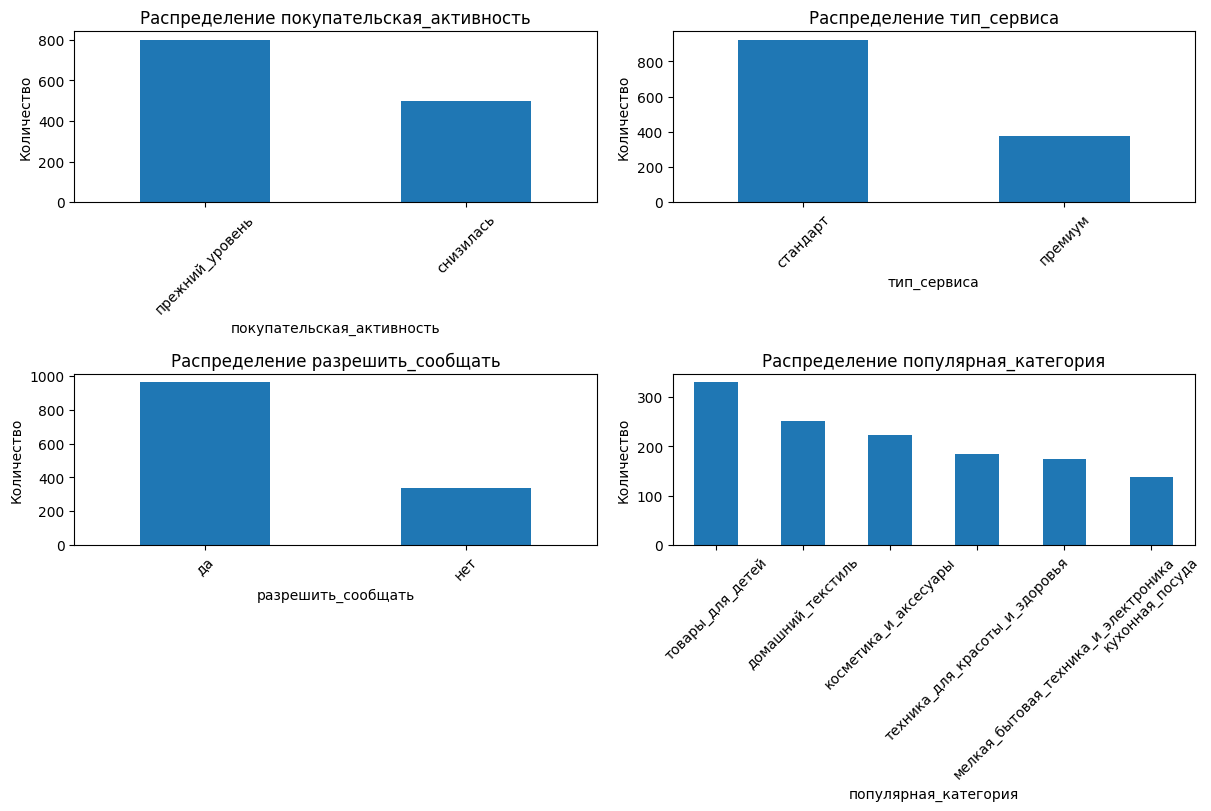

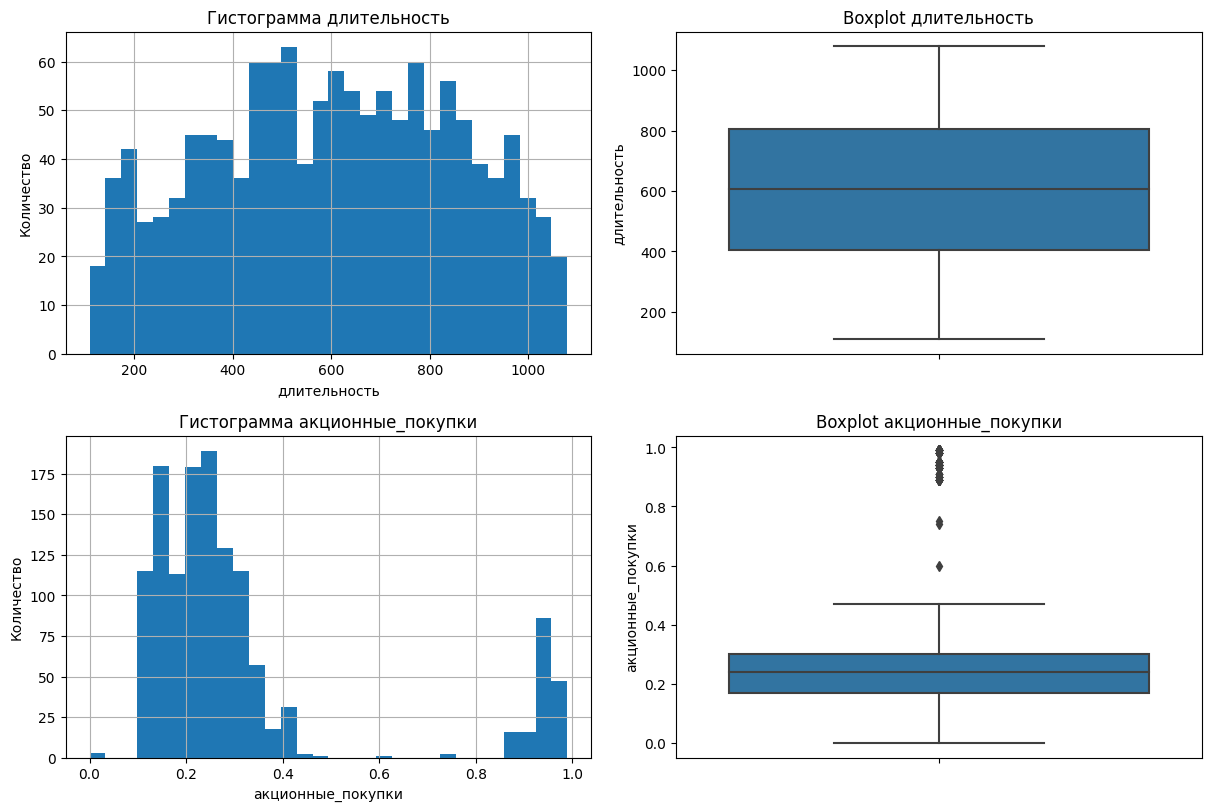

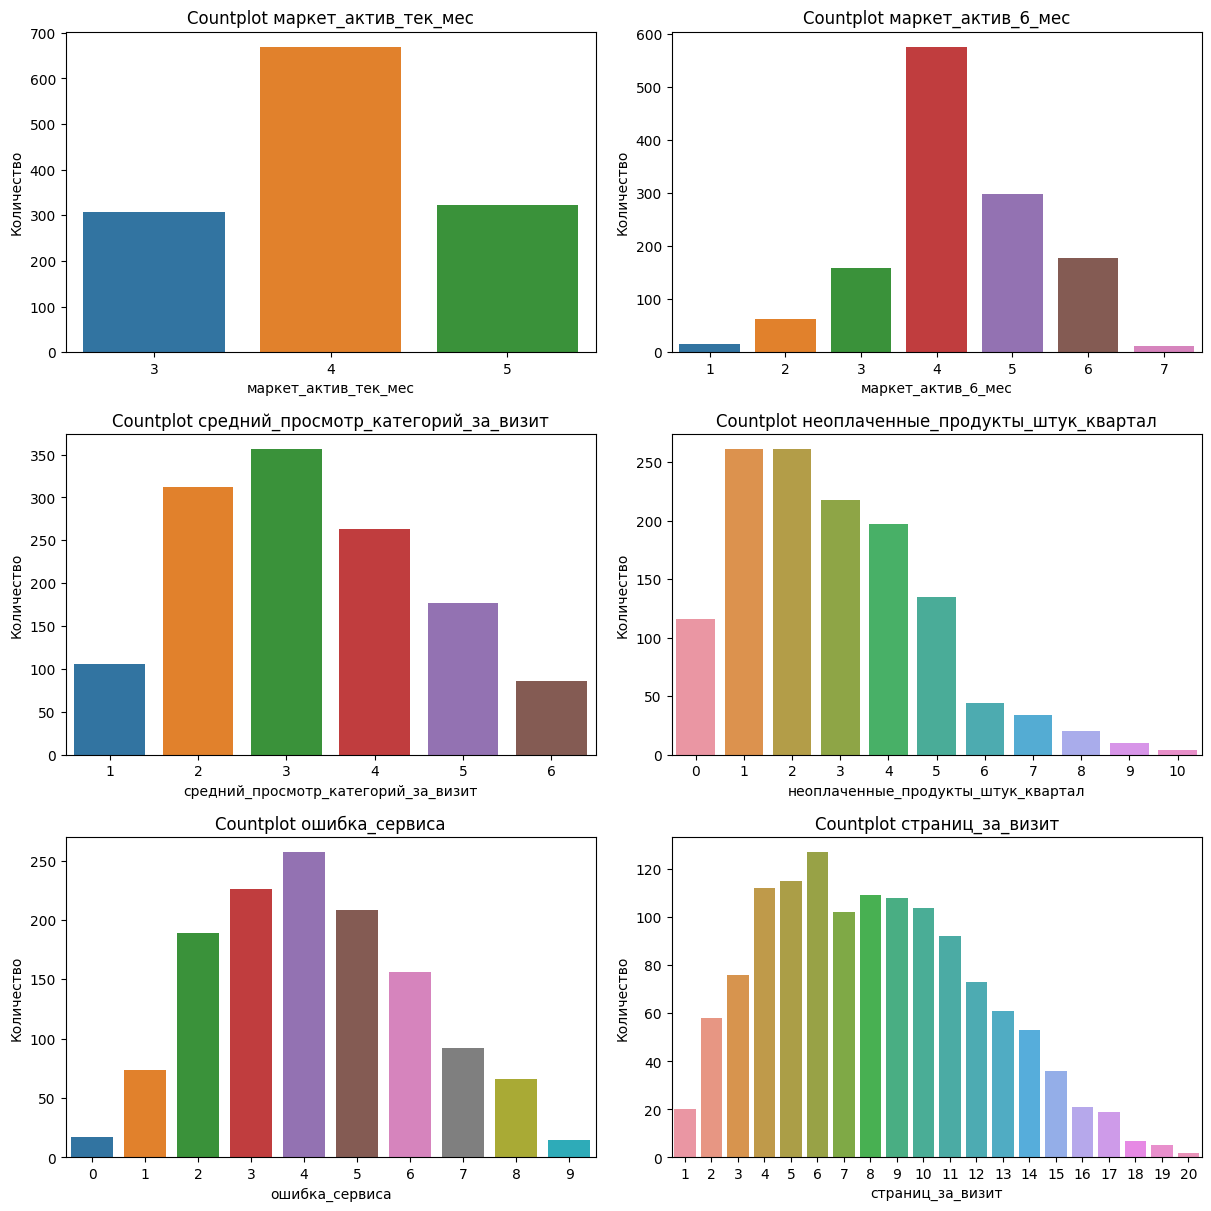

In [26]:
#строим графики для data_market

df_plot(data_market,
        boxplot=('длительность', 'акционные_покупки'),
        exclude=('id'),
        discrete=('маркет_актив_тек_мес', 'маркет_актив_6_мес', 'средний_просмотр_категорий_за_визит',
                 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит')
       )

In [27]:
#описательная статистика для data_market
data_market.describe().round(1)

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.0,1300.0,1300.0,1300.0,1300.0,1300.0,1300.0,1300.0,1300.0
mean,215997.5,4.3,4.0,601.9,0.3,3.3,2.8,4.2,8.2
std,375.4,1.1,0.7,249.9,0.2,1.4,2.0,2.0,4.0
min,215348.0,1.0,3.0,110.0,0.0,1.0,0.0,0.0,1.0
25%,215672.8,4.0,4.0,405.5,0.2,2.0,1.0,3.0,5.0
50%,215997.5,4.0,4.0,606.0,0.2,3.0,3.0,4.0,8.0
75%,216322.2,5.0,4.0,806.0,0.3,4.0,4.0,6.0,11.0
max,216647.0,7.0,5.0,1079.0,1.0,6.0,10.0,9.0,20.0


In [28]:
#посмотрим какая доля акционных покупок у обычных и премиум пользователей
data_market.groupby("тип_сервиса")["акционные_покупки"].mean()

тип_сервиса
премиум     0.335851
стандарт    0.313279
Name: акционные_покупки, dtype: float64

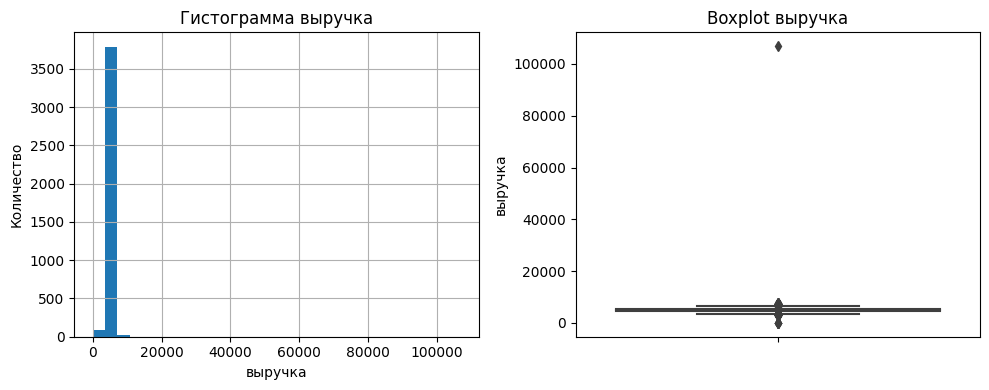

In [29]:
#строим графики для data_market_revenue
df_plot(data_market_revenue, col='выручка', boxplot=('выручка'), ncols=2)

In [30]:
#видим аномалию в выручке, удалим ее
data_market_revenue = data_market_revenue[data_market_revenue['выручка'] < 100000]

#& (data_market_revenue['выручка'] > 100)

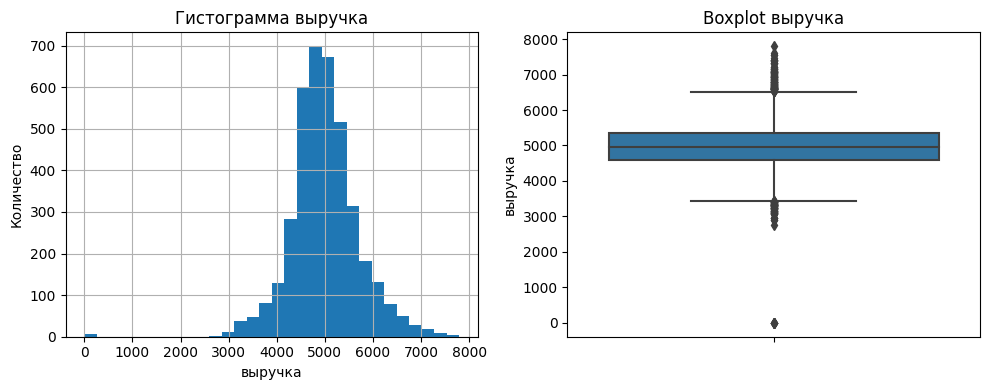

In [31]:
#смотрим на график без верхнего выброса
df_plot(data_market_revenue, col='выручка', boxplot=('выручка'), ncols=2)

In [32]:
#описательная статистика для data_market_revenue['выручка']
data_market_revenue['выручка'].describe().round(1)

count    3899.0
mean     4999.6
std       707.0
min         0.0
25%      4590.1
50%      4957.0
75%      5363.0
max      7799.4
Name: выручка, dtype: float64

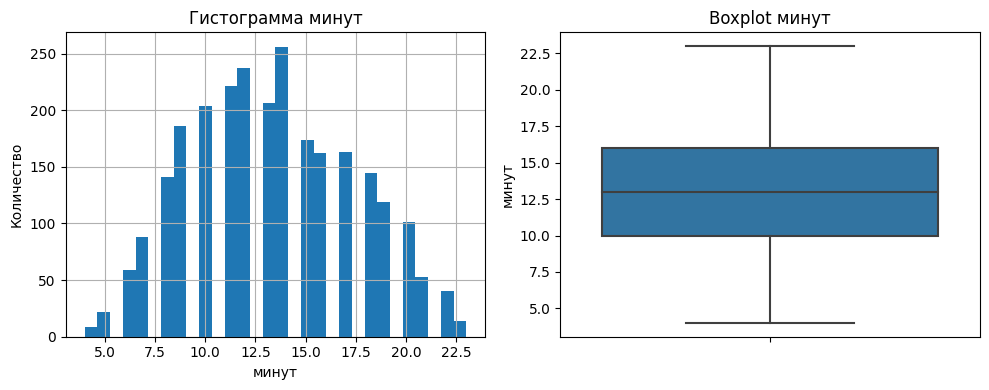

In [33]:
#строим графики для data_market_time
df_plot(data_market_time, col='минут', boxplot=('минут'), ncols=2)

In [34]:
#описательная статистика для data_market_time['минут']
data_market_time['минут'].describe().round(1)

count    2600.0
mean       13.3
std         4.1
min         4.0
25%        10.0
50%        13.0
75%        16.0
max        23.0
Name: минут, dtype: float64

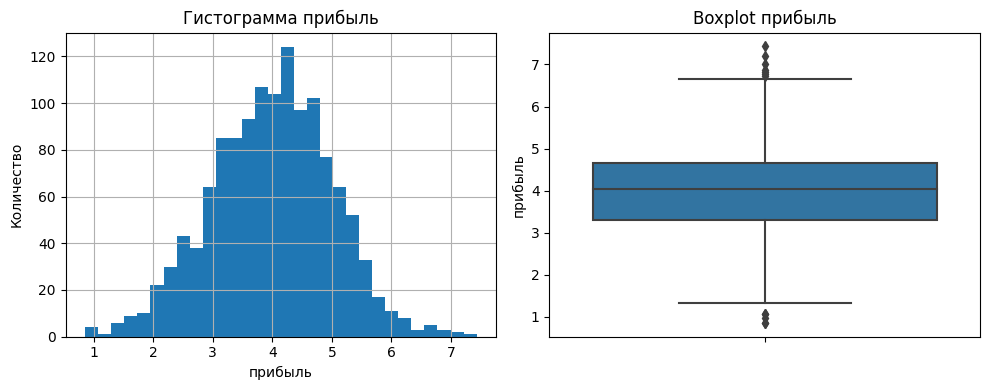

In [35]:
#строим графики для data_market_income
df_plot(data_market_income, col='прибыль', boxplot=('прибыль'), ncols=2)

In [36]:
#описательная статистика для data_market_income['прибыль']
data_market_income['прибыль'].describe().round(1)

count    1300.0
mean        4.0
std         1.0
min         0.9
25%         3.3
50%         4.0
75%         4.7
max         7.4
Name: прибыль, dtype: float64

**Промежуточный вывод:**
<br>
<br>
Качественные признаки
- Покупательская активность пользователей распределена неравномерно (60% прежний уровень, 40% снижена).
- "Тип сервиса": преобладает "стандарт", "премиум" пользователей заметно меньше. Доля акционных покупок у данных категорий пользователей примерно равен (33% премиум, 31% стандарт).
- Большинство пользователей разрешают отправку предложений товаров от сервиса.
- Самая популярная категория товаров за последние 6 месяцев – "товары для детей", наименее популярная – "кухонная посуда".
<br>

Количественные признаки
- "Среднемесячное число маркетинговых коммуникаций с пользователями за последние 6 месяцев" – нормальное распределение с выбросами по нижней границе, обычно пользователь получает 4 звонка/рекламы и т.п. За текущий месяц число коммуникаций составляет практически константный признак.
- "Длительность" (дней с момента регистрации на сайте): сильный разброс значений, в среднем у пользователей выборки прошло 600 дней с регистрации (стандартное отклонение 250 дней).
- "Ацидионные покупки": большая часть значений ближе к нулю (медиана 20% акционных покупок), но есть группа пользователей, которые покупают только акционные товары (80% и выше доля покупок по акциям).
- "Средний просмотр категорий за визит": чаще смотрят 2-4 категории, редко больше.
- "Неоплаченные продукты за последние 3 месяца": распределение правостороннее, чаще 0-3 товаров.
- "Ошибки сервиса за последние 3 месяца": распределение похоже на нормальное, с центром около 4.
- "Страниц за визит": распределение близко к нормальному, медиана около 8.
- Выручка распределена нормально, в среднем 5 тысяч рублей с пользователя.
- Время проведенное на сайте за месяц – в среднем 13 минут.

## Объединение таблиц

In [37]:
#изменим таблицу с выручкой для дальнейшего объединения

data_market_revenue = (
    data_market_revenue
    .pivot(index='id', columns='период', values='выручка')
    .rename(columns={
        'текущий_месяц': 'выручка_1_месяц',
        'предыдущий_месяц': 'выручка_2_месяц',
        'препредыдущий_месяц': 'выручка_3_месяц'
    })
    .reset_index()
)

In [38]:
data_market_revenue.head()

период,id,выручка_2_месяц,выручка_3_месяц,выручка_1_месяц
0,215348,0.0,0.0,3293.1
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5


In [39]:
#проверяем на пропуски
data_market_revenue.isna().sum()

период
id                 0
выручка_2_месяц    0
выручка_3_месяц    0
выручка_1_месяц    1
dtype: int64

In [40]:
#заполним пропуски нулями
data_market_revenue = data_market_revenue.fillna(0)
data_market_revenue.isna().sum()

период
id                 0
выручка_2_месяц    0
выручка_3_месяц    0
выручка_1_месяц    0
dtype: int64

In [41]:
#проверяем таблицу с выручкой на строки с 0 по всем периодам + выручка < 100

print('Строк с 0 по всем периодам и выручкой < 100:', len(data_market_revenue[
    (data_market_revenue[['выручка_1_месяц', 'выручка_2_месяц', 'выручка_3_месяц']].sum(axis=1) == 0) | 
    (data_market_revenue[['выручка_1_месяц', 'выручка_2_месяц', 'выручка_3_месяц']] < 100).any(axis=1)
]))

Строк с 0 по всем периодам и выручкой < 100: 4


In [42]:
#удалим строки с выбросами
data_market_revenue = data_market_revenue[
    ~(
        (data_market_revenue[['выручка_1_месяц', 'выручка_2_месяц', 'выручка_3_месяц']].sum(axis=1) == 0) | 
        (data_market_revenue[['выручка_1_месяц', 'выручка_2_месяц', 'выручка_3_месяц']] < 100).any(axis=1)
    )
]

In [43]:
#изменим таблицу с временем на сайте для дальнейшего объединения

data_market_time = (
    data_market_time
    .pivot(index='id', columns='период', values='минут')
    .rename(columns={
        'текущий_месяц': 'минут_на_сайте_1_месяц',
        'предыдущий_месяц': 'минут_на_сайте_2_месяц'
    })
    .reset_index()
)

In [44]:
data_market_time.head()

период,id,минут_на_сайте_2_месяц,минут_на_сайте_1_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


In [45]:
data_market_time.isna().sum()

период
id                        0
минут_на_сайте_2_месяц    0
минут_на_сайте_1_месяц    0
dtype: int64

In [46]:
#объединяем таблицы по id

data_market = (
    data_market
    .merge(data_market_revenue, on="id", how="inner")
    .merge(data_market_time, on="id", how="inner")
)

In [47]:
data_market.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_2_месяц,выручка_3_месяц,выручка_1_месяц,минут_на_сайте_2_месяц,минут_на_сайте_1_месяц
0,215349,снизилась,премиум,да,4,4,819,0.75,товары_для_детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,снизилась,стандарт,нет,5,3,539,0.14,домашний_текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,снизилась,стандарт,да,3,5,896,0.99,товары_для_детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,снизилась,стандарт,нет,5,3,1064,0.94,товары_для_детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,снизилась,стандарт,да,3,4,762,0.26,домашний_текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [48]:
data_market.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   int32  
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

**Промежуточный вывод:** удалили выбросы в данных о выручке, объединили таблицы `data_market`, `data_market_revenue`, `data_market_time` по id пользователей, устранили пропуски.

## Корреляционный анализ

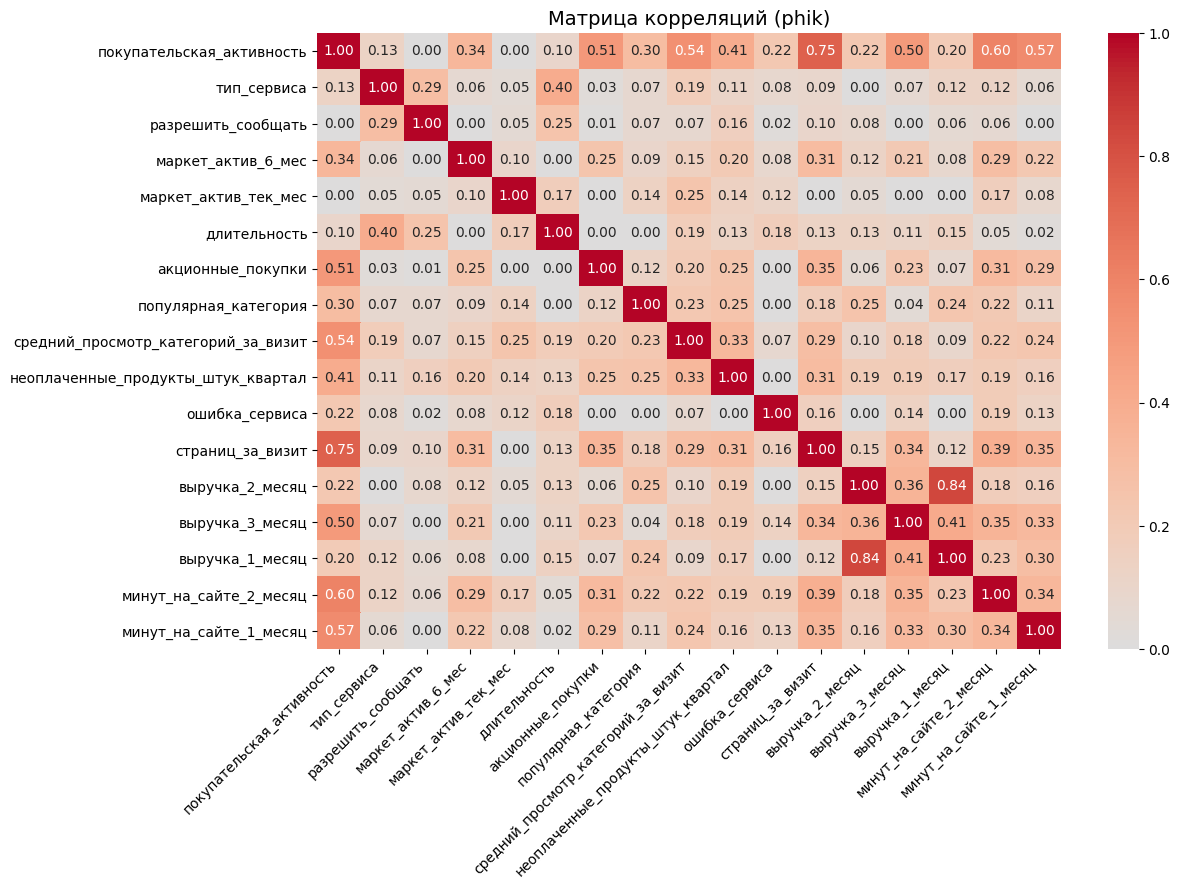

In [49]:
# исключаем колонку c id
data_market_corr = data_market.drop(columns=['id'])

#список непрерывных признаков
interval_cols = [
    'длительность',
    'акционные_покупки',
    'выручка_1_месяц',
    'выручка_2_месяц',
    'выручка_3_месяц'
]

#вычисляем матрицу корреляций с phik
phik_matrix_first = data_market_corr.phik_matrix(interval_cols=interval_cols)

#строим тепловую карту
plt.figure(figsize=(12, 8))
sns.heatmap(
    phik_matrix_first, 
    annot=True,
    fmt=".2f",
    cmap="coolwarm", 
    center=0
)
plt.title("Матрица корреляций (phik)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.show()

In [50]:
#устраним мультиколлинеарность между `выручка_1_месяц` и `выручка_2_месяц`

# создаём новый столбец — средняя за последние 2 месяца
data_market_corr['выручка_средняя_за_2_месяца'] = (data_market_corr['выручка_1_месяц'] + data_market_corr['выручка_2_месяц']) / 2
data_market['выручка_средняя_за_2_месяца'] = (data_market['выручка_1_месяц'] + data_market['выручка_2_месяц']) / 2

# удаляем старые столбцы
data_market_corr = data_market_corr.drop(columns=['выручка_1_месяц', 'выручка_2_месяц'])
data_market = data_market.drop(columns=['выручка_1_месяц', 'выручка_2_месяц'])

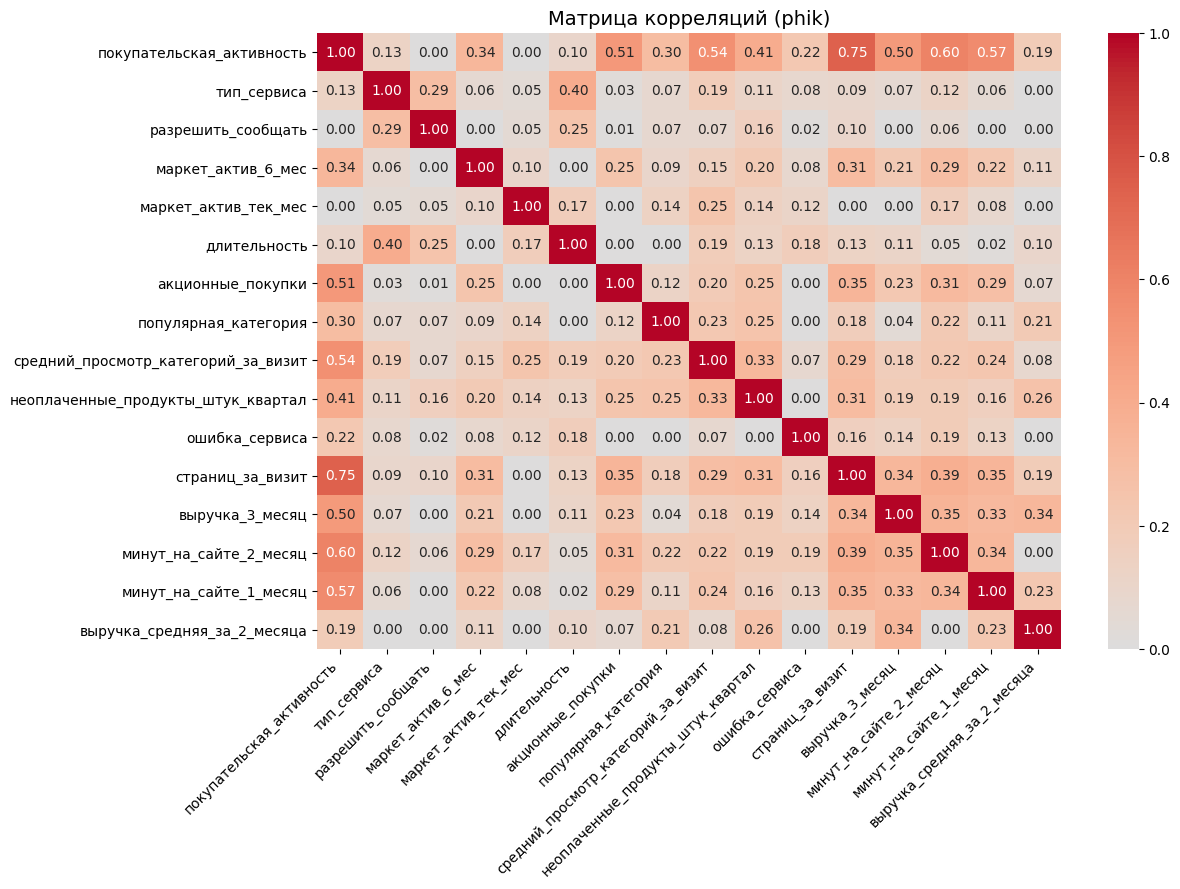

In [51]:
#еще раз строим матрицу корреляций, чтобы убедиться в отсутствии мультиколлинеарности

#новый список непрерывных признаков
interval_cols = [
    'длительность',
    'акционные_покупки',
    'выручка_средняя_за_2_месяца',
    'выручка_3_месяц'
]

phik_matrix_second = data_market_corr.phik_matrix(interval_cols=interval_cols)

#строим тепловую карту
plt.figure(figsize=(12, 8))
sns.heatmap(
    phik_matrix_second, 
    annot=True,
    fmt=".2f",
    cmap="coolwarm", 
    center=0
)
plt.title("Матрица корреляций (phik)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.show()

**Промежуточный вывод:** Самая высокая корреляция у признаков "выручка за текущий месяц" и "выручка за предыдущий месяц" (0.84). Это мультиколлинеарность, заменили эти признаки новым "средняя выручка за последние 2 месяца".

Корреляции целевого признака:
- Первая по значимости корреляция у признаков "покупательская активность" и "страниц за визит" (0.75).
- "Покупательская активность" и "минут на сайте в прошлом месяце" (0.6).
- "Покупательская активность" и "минут на сайте в текущем месяце" (0.57).
- "Покупательская активность" и "просмотр категорий за визит" (0.54).
- "Покупательская активность" и "акционные покупки" (0.51).
- "Покупательская активность" и "выручка за препредыдущий месяц" (0.5).
- "Покупательская активность" и "неоплаченные товары" (0.41).
- "Покупательская активность" и "маркетинговая активность за последние 6 месяцев" (0.34).

<br>
Таким образом, большая часть высоких корреляций связана с временем нахождения пользователя на сайте (время сессии, просмотр категорий, количество страниц).

## Использование пайплайнов

В качестве метрики выбираем roc_auc, причины:
- подходит для несбалансированных классов (наш целевой признак `'покупательская_активность'`).
- показывает риск снижения покупательской активности пользователя, можно выбрать тех, кому покажем новые акции или персональные предложения.
- работает со всеми моделями.

In [52]:
RANDOM_STATE = 42

In [53]:
#разделяем выборку на тренировочную и тестовую

X_train, X_test, y_train, y_test = train_test_split(
    data_market.drop(['покупательская_активность'], axis=1),
    data_market['покупательская_активность'],
    test_size = 0.25, 
    random_state = RANDOM_STATE,
    stratify = data_market['покупательская_активность'])

In [54]:
#удалим колонку с id

X_train_ids = X_train['id'].reset_index(drop=True)
X_test_ids = X_test['id'].reset_index(drop=True)

X_train = X_train.drop(columns=['id'])
X_test = X_test.drop(columns=['id'])

In [55]:
# создаём списки с названиями признаков

ohe_columns = ['популярная_категория']
ord_columns = ['тип_сервиса', 'разрешить_сообщать']
num_columns = [
    'ошибка_сервиса', 'маркет_актив_тек_мес', 'маркет_актив_6_мес', 'длительность', 'акционные_покупки',
    'средний_просмотр_категорий_за_визит','неоплаченные_продукты_штук_квартал', 'страниц_за_визит',
    'выручка_средняя_за_2_месяца', 'выручка_3_месяц', 'минут_на_сайте_1_месяц', 'минут_на_сайте_2_месяц'
]

In [56]:
#первый пайплайн для ohe кодирования

ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
 )

In [57]:
#второй пайплайн для ordinal кодирования

ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord',  OrdinalEncoder(categories=[
                ['стандарт', 'премиум'],
                ['нет', 'да']
            ], handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [58]:
#объединяем пайплайны кодирования, добавляем масштабирование

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)    
    ], 
    remainder='passthrough'
)

In [59]:
#создаем финальный пайплайн с моделью

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [60]:
#создаем пайплайн с вариантами моделей, масштабирования и гиперпараметров

param_grid = [
    #словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(1, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    #словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    #словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    #словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            probability=True
        )],
        'models__C': [0.1, 1, 10],
        'models__kernel': ['linear', 'rbf'],
        'models__gamma': ['scale', 'auto'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [61]:
#убираем предупреждения юпитера
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [62]:
#обучаем модели через поиск лучших параметров

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:', randomized_search.best_estimator_.named_steps['models'])
print('Ядро модели:', randomized_search.best_estimator_.named_steps['models'].kernel)
print('Масштабирование:', randomized_search.best_estimator_.named_steps['preprocessor'].named_transformers_['num'])
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_.round(3))

Лучшая модель и её параметры: SVC(C=0.1, kernel='linear', probability=True, random_state=42)
Ядро модели: linear
Масштабирование: MinMaxScaler()
Метрика лучшей модели на кросс-валидации: 0.896


In [63]:
#проверяем модель на тестовой выборке

y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {(roc_auc_score(y_test, y_test_pred)).round(3)}')

Метрика ROC-AUC на тестовой выборке: 0.922


**Промежуточный вывод:**
1. Создали несколько пайплайнов для кодирования, масштабирования признаков.
2. Создали финальный пайплайн, который перебирает варианты из 4 моделей, 2 масштабирований и гиперпараметров.
3. В качестве метрики выбрали roc_auc, причины:
    - подходит для несбалансированных классов (наш целевой признак `'покупательская_активность'`).
    - показывает риск снижения покупательской активности пользователя, можно выбрать тех, кому покажем новые акции или персональные предложения.
    - работает со всеми моделями.
3. Методом случайного поиска обучили и нашли лучшую модель с характеристиками:
    - Модель опорных векторов, ядро rbf.
    - Масштабирование MinMaxScaler().
    - Метрика roc_auc: 0.897.
4. Проверили на тестовой выборке – метрика 0.922, переобучения или недообучения не выявлено.

## Анализ важности признаков

Вычисляем SHAP значения... (это может занять некоторое время)


  0%|          | 0/50 [00:00<?, ?it/s]

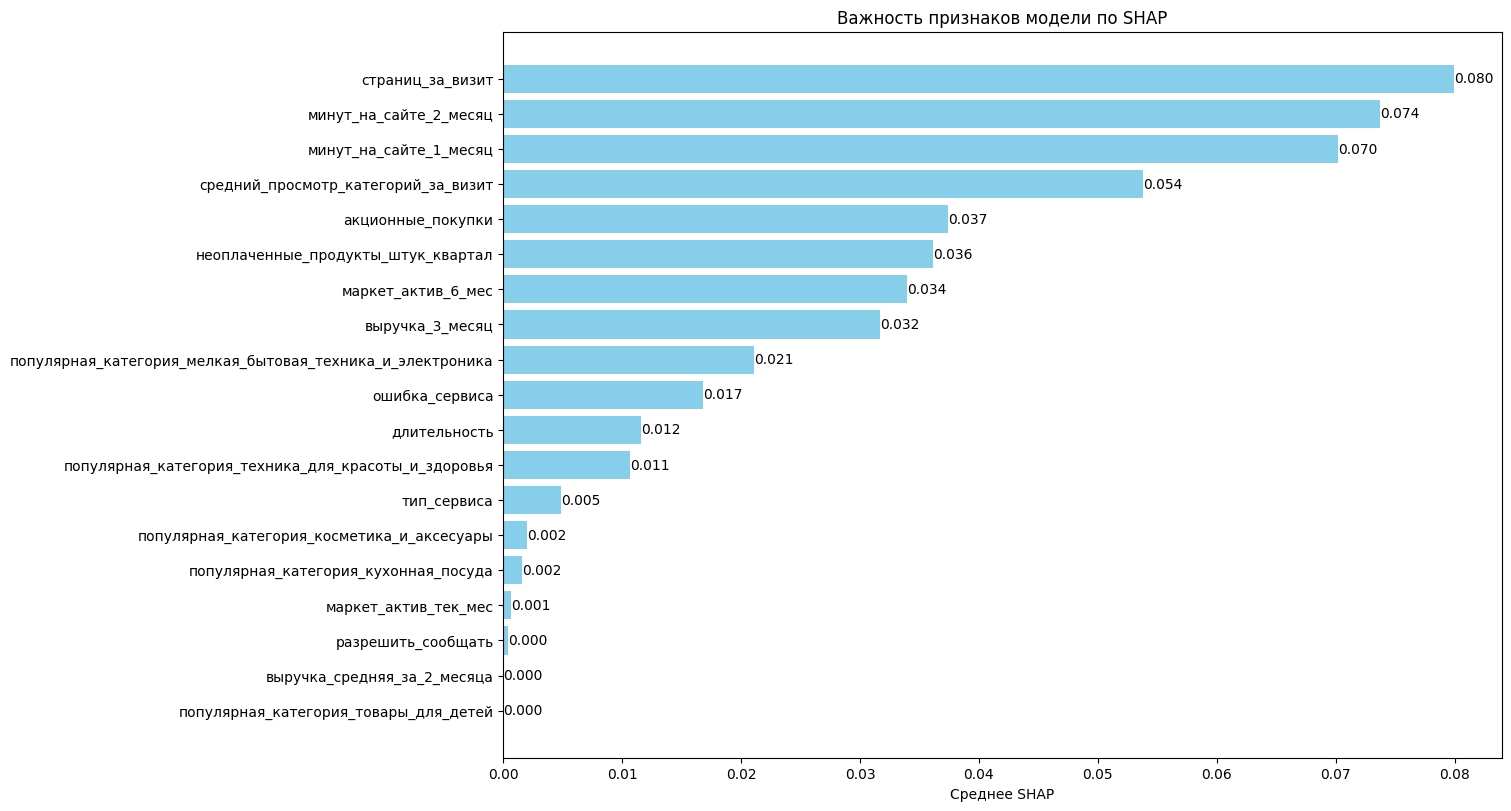

In [64]:
#извлекаем лучшую модель
best_model = randomized_search.best_estimator_.named_steps['models']

#готовим данные (трансформируем через препроцессор без модели)
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

#получаем реальные имена признаков после всех преобразований

#OHE признаки
ohe_step = preprocessor.named_transformers_['ohe'].named_steps['ohe']
ohe_feature_names = ohe_step.get_feature_names_out(ohe_columns)

#Ordinal и числовые признаки
ord_feature_names = ord_columns
num_feature_names = num_columns

#финальный список имен признаков
feature_names = list(ohe_feature_names) + ord_feature_names + num_feature_names

#берем небольшие подвыборки для скорости расчета SHAP (50 шт)
background = resample(X_train_preprocessed, n_samples=50, random_state=42)
X_test_sample = resample(X_test_preprocessed, n_samples=50, random_state=42)

#определяем функцию предсказания для SHAP
def predict_function(X):
    return best_model.predict_proba(X)[:, 1]

#создаем объяснитель и вычисляем SHAP значения
print("Вычисляем SHAP значения... (это может занять некоторое время)")
explainer = shap.KernelExplainer(predict_function, background)
shap_values = explainer.shap_values(X_test_sample)

#cредние абсолютные значения SHAP
shap_abs_mean = np.abs(shap_values).mean(axis=0)

#сортировка по убыванию
indices = np.argsort(shap_abs_mean)[::-1]
shap_sorted = shap_abs_mean[indices]
features_sorted = [feature_names[i] for i in indices]

#строим график важности признаков
fig, ax = plt.subplots(figsize=(15, 8), constrained_layout=True)
bars = ax.barh(features_sorted, shap_sorted, color='skyblue')
ax.set_xlabel("Среднее SHAP")
ax.set_title("Важность признаков модели по SHAP")

#добавляем подписи значений над столбцами
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2,
        f"{width:.3f}", va='center')
    
ax.invert_yaxis()
plt.show()

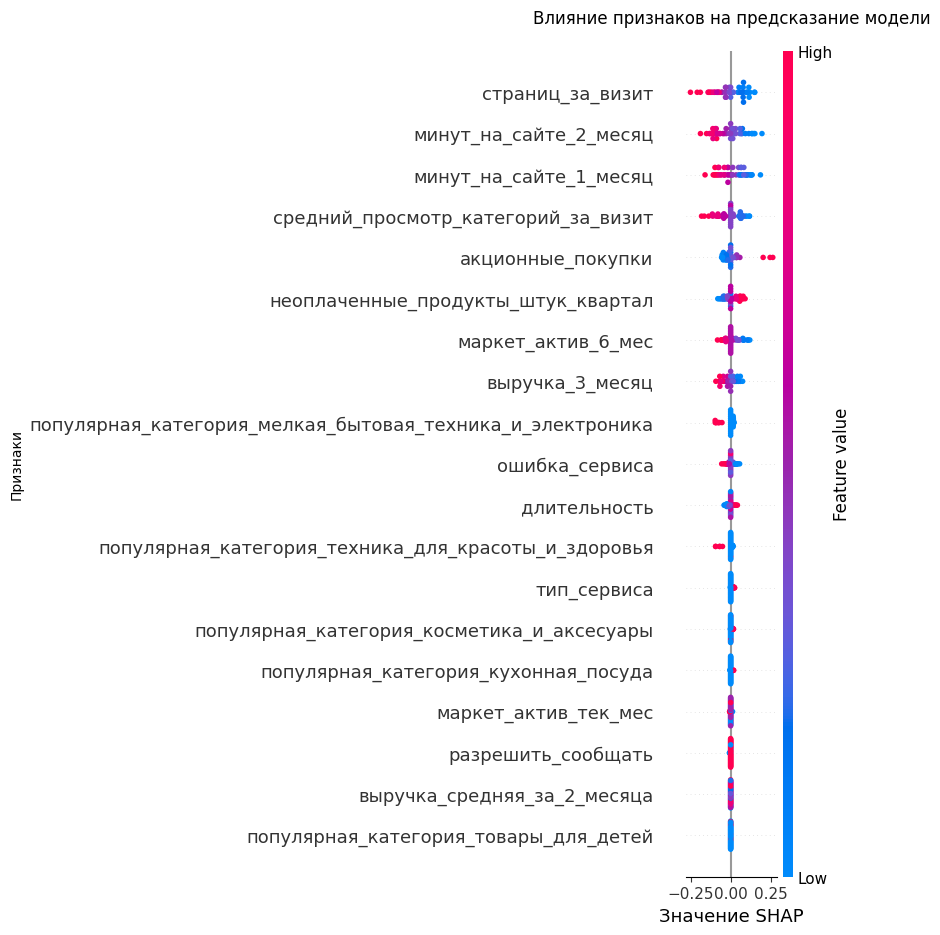

In [65]:
#смотрим как именно влияют признаки на целевой

shap.summary_plot(
    shap_values, 
    X_test_sample, 
    feature_names=feature_names, 
    plot_type="dot", 
    show=False
)

plt.title("Влияние признаков на предсказание модели", pad=20)
plt.xlabel("Значение SHAP")
plt.ylabel("Признаки")
plt.show()

In [66]:
#в sklearn метки кодируются по алфавиту, так что первый 0, второй 1
print(best_model.classes_)

['прежний_уровень' 'снизилась']


**Промежуточный вывод:**
1. Чем дольше время визита на сайте, тем меньше шанс снижения покупательской активности (важность 0.07).
2. Аналогично с просмотром категорий – больше = лучше (важность 0.065).
3. Чем больше просмотренных страниц за визит, тем меньше шанс снижения покупательской активности (важность 0.063).
4. Высокий процент акционных покупок снижает покупательскую активность (важность 0.061).
5. Высокое количество неоплаченных товаров увеличивает шанс снижения покупательской способности (важность 0.037).
6. Маркетинговая активность за последние 6 месяцев: чем больше спецпредложений получает клиент, тем ниже шанс снижения покупательской активности (важность 0.033).

<br>
Маркетинговая активность за последний месяц на целевой признак не влияет совсем, значит снижение покупательской активности это растянутый на месяцы процесс.

## Сегментация покупателей

In [67]:
#возвращаем колонку с id в тестовую выборку

#получаем вероятности для класса 1 (снижение покупательской активности)
y_prob = best_model.predict_proba(X_test_preprocessed)[:, 1]

#создаём DataFrame с обработанными данными
X_test_new = pd.DataFrame(X_test_preprocessed, columns=feature_names)

#добавляем id и pred_proba в тестовую выборку
X_test_new = pd.concat(
    [X_test_new, pd.DataFrame({'id': X_test_ids.values, 'pred_proba': y_prob})],
    axis=1
)

#добавляем колонку 'прибыль' в тестовую выборку
X_test_new = X_test_new.merge(data_market_income[['id', 'прибыль']], on='id', how='left')

In [68]:
X_test_new.head()

,популярная_категория_косметика_и_аксесуары,популярная_категория_кухонная_посуда,популярная_категория_мелкая_бытовая_техника_и_электроника,популярная_категория_техника_для_красоты_и_здоровья,популярная_категория_товары_для_детей,тип_сервиса,разрешить_сообщать,ошибка_сервиса,маркет_актив_тек_мес,маркет_актив_6_мес,...,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,страниц_за_визит,выручка_средняя_за_2_месяца,выручка_3_месяц,минут_на_сайте_1_месяц,минут_на_сайте_2_месяц,id,pred_proba,прибыль
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.444444,0.5,0.500000,...,1.0,0.1,0.578947,0.152130,0.520128,0.684211,0.611111,216161,0.010734,4.69
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.111111,0.5,0.000000,...,0.4,0.6,0.263158,0.205489,0.356550,0.263158,0.333333,215654,0.987226,2.75
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.888889,0.5,0.333333,...,0.6,0.2,0.473684,0.680183,0.298403,0.368421,0.833333,216307,0.103927,3.16
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.555556,0.0,0.500000,...,0.6,0.3,0.263158,0.865205,0.571885,0.263158,0.222222,215501,0.765984,3.74
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.5,0.833333,...,0.0,0.2,0.315789,0.573113,0.225559,0.736842,0.555556,215934,0.493608,4.40


In [69]:
#получим id пользователей с высокой прибылью и высоким риском снижения покупательской способности (выше 75 процентиля)
q75_income = data_market_income['прибыль'].quantile(0.75)
q50_pred = X_test_new['pred_proba'].quantile(0.5)

#получаем id нужных клиентов по фильтру
high_profit_ids = X_test_new[
    (X_test_new['прибыль'] >= q75_income) &
    (X_test_new['pred_proba'] >= q50_pred)
]['id'].values

In [70]:
#оставим нужных клиентов в выборке

high_profit_data = data_market[
    (data_market['id'].isin(high_profit_ids)) &
    (data_market['покупательская_активность'] == 'прежний_уровень')
]

print('Число прибыльных клиентов с высоким риском снижения покупательской активности: ', high_profit_data.shape[0])
print('Средняя прибыль с клиента в этом сегменте: ', X_test_new.loc[X_test_new['прибыль'] >= q75_income, 'прибыль'].mean())

Число прибыльных клиентов с высоким риском снижения покупательской активности:  9
Средняя прибыль с клиента в этом сегменте:  5.200142857142858


In [71]:
high_profit_data = high_profit_data.merge(X_test_new[['id', 'pred_proba']], on='id', how='left')
high_profit_data

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_3_месяц,минут_на_сайте_2_месяц,минут_на_сайте_1_месяц,выручка_средняя_за_2_месяца,pred_proba
0,215769,прежний_уровень,стандарт,нет,4,3,553,0.23,домашний_текстиль,5,3,3,10,4495.0,12,9,5250.15,0.375523
1,215967,прежний_уровень,стандарт,нет,4,3,775,0.15,косметика_и_аксесуары,4,2,4,4,4382.0,8,22,6038.00,0.451542
2,216119,прежний_уровень,премиум,да,4,3,208,0.13,косметика_и_аксесуары,5,2,1,10,5154.0,12,8,5004.00,0.247170
3,216191,прежний_уровень,стандарт,да,5,4,177,0.44,косметика_и_аксесуары,3,2,2,7,4970.0,16,11,6032.60,0.376224
4,216252,прежний_уровень,премиум,да,4,3,1036,0.17,товары_для_детей,4,2,2,4,4536.0,11,16,4275.95,0.614311
5,216306,прежний_уровень,премиум,да,4,4,370,0.21,косметика_и_аксесуары,2,4,1,15,4995.0,13,7,5502.90,0.459568
6,216350,прежний_уровень,стандарт,да,4,4,802,0.30,кухонная_посуда,2,3,6,9,4807.0,16,16,5747.05,0.309626
7,216460,прежний_уровень,стандарт,да,4,5,237,0.95,техника_для_красоты_и_здоровья,4,3,4,4,4845.0,15,22,4772.30,0.315530
8,216615,прежний_уровень,стандарт,да,5,4,780,0.27,домашний_текстиль,4,1,4,4,5360.0,11,12,4982.10,0.352296


In [72]:
#функция для графиков дискретных значений

def df_plot_multiple(df, columns, col=2):
    n = len(columns)
    rows = math.ceil(n / col)
    fig, axes = plt.subplots(rows, col, figsize=(6*col, 4*rows))
    axes = axes.flatten()
    
    for i, column in enumerate(columns):
        sns.countplot(x=column, data=df, ax=axes[i], palette='viridis')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Количество')
        axes[i].set_title(f'Распределение по {column}')
    
    #если графиков меньше, чем ячеек сетки, скрываем лишние
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

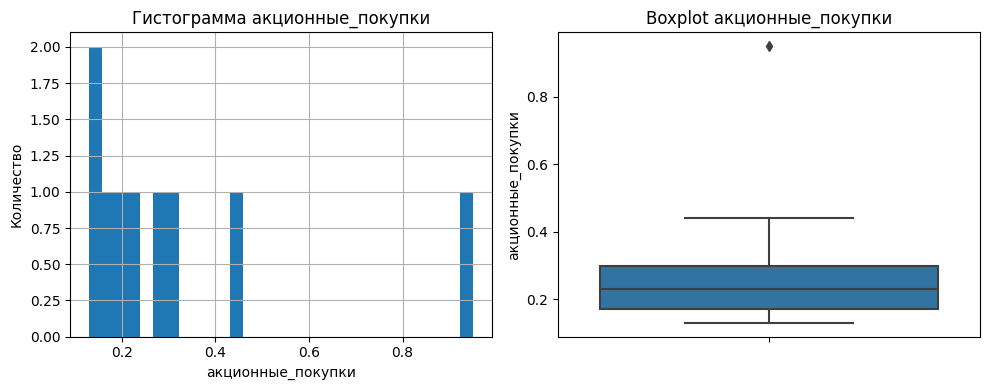

In [73]:
#строим графики для наших избранных клиентов по наиболее важным признакам

df_plot(high_profit_data, col='акционные_покупки', boxplot=('акционные_покупки'), ncols=2)

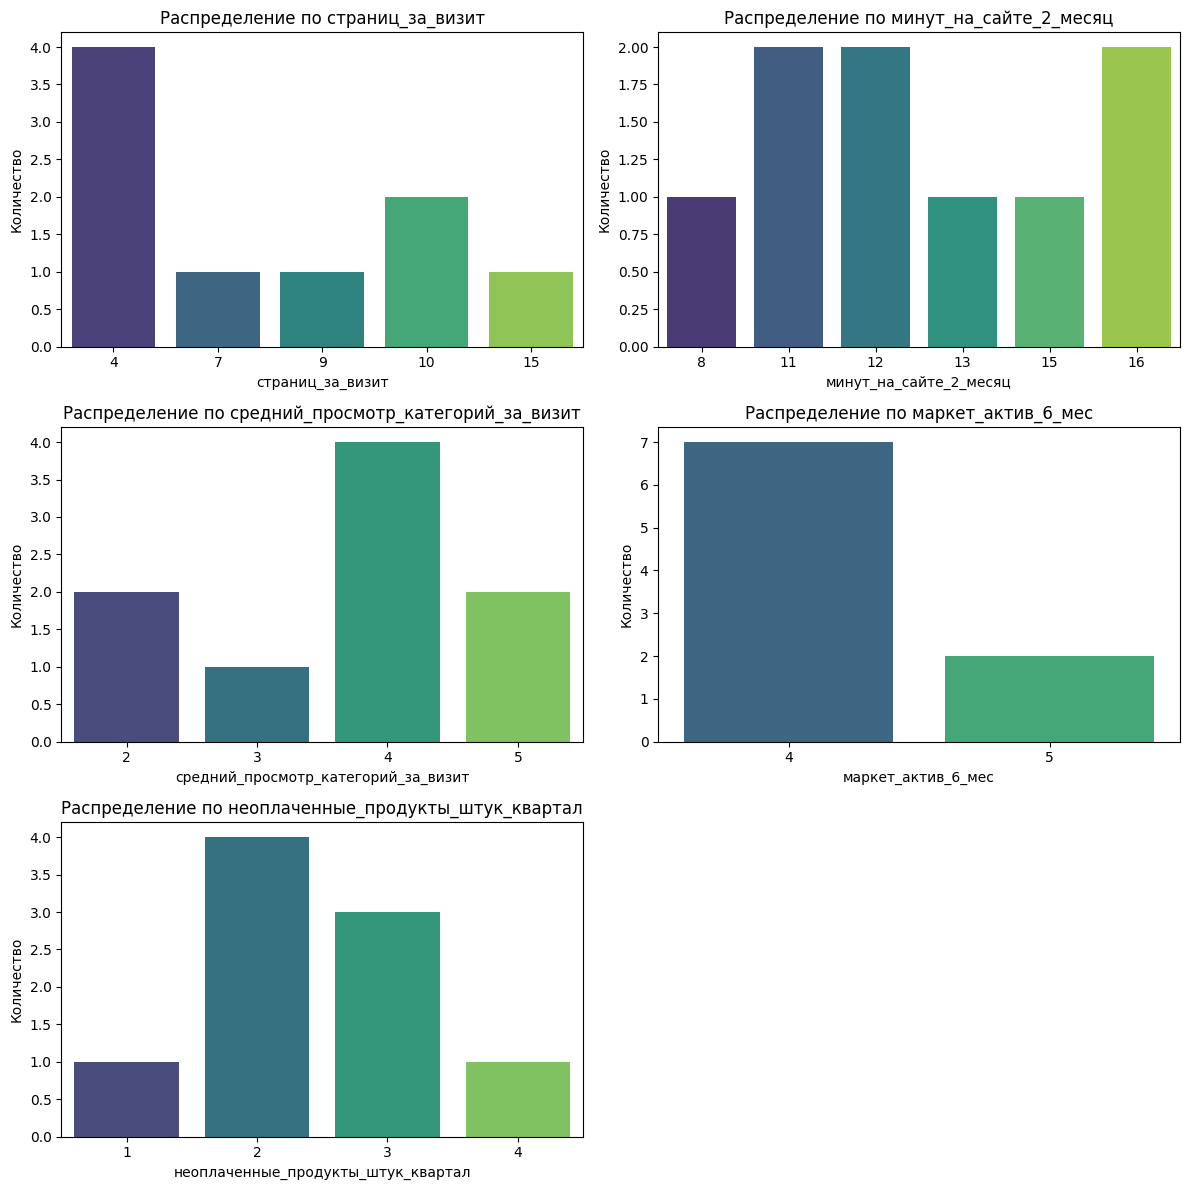

In [74]:
#дискретные
df_plot_multiple(high_profit_data, columns=('страниц_за_визит', 'минут_на_сайте_2_месяц',
                                            'средний_просмотр_категорий_за_визит', 'маркет_актив_6_мес',
                                            'неоплаченные_продукты_штук_квартал'
                                            )
)

**Промежуточный вывод:**

<br>
Мы отобрали сегмент из 10 пользователей по критериям:

- высокая прибыль за 3 последних месяца (5.2 условных единиц в среднем, показатель выше 75% остальных клиентов).
- повышенный риск перехода из категории "прежняя покупательская активность" в "сниженная".

Исследовательский анализ сегмента:
1. Большинство пользователей сегмента мало пользуются акциями (менее 30% акционных покупок).
2. Среднее время на сайте 12 минут в месяц (на минуту меньше, чем среднее по всем пользователям).
3. Менее 4 неоплаченных покупок за последние 3 месяца.
4. В среднем 4.2 маркетинговых коммуникаций за 6 месяцев.

Предложения:
1. Делать слишком много акционных предложений клиентам не стоит, т.к. текущий показатель уже выше среднего (20%). Можно в качестве теста увеличить показатель, но отслеживать его рост. Выше 50% уже точно приводит к риску снижения покупательской активности.
2. Показатели времени на сайте должны вырасти вслед за увеличением персональных предложений. Это также уменьшит риск снижения покупательской активности.
3. Стоит увеличить число маркетинговых коммуникаций - снова пересечение с персональными предложениями / акциями, главное донести это до пользователя. Кроме акций можно предлагать персонализированные подборки и едининчные товары.

## Общий вывод

Мы разработали модель, которая предсказывает риск снижения покупательской способности у пользователей интернет-магазина, проанализировали важность признаков и предложили способы для снижения риска.

<b>Анализ данных:</b>
1. В выборку попали 1300 пользователей интернет-магазина с показателями за 3-6 последних месяцев.
2. Качественные признаки:
    - Покупательская активность пользователей распределена неравномерно (60% прежний уровень, 40% снижена).
    - "Тип сервиса": преобладает "стандарт", "премиум" пользователей заметно меньше. Доля акционных покупок у данных категорий пользователей примерно равен (33% премиум, 31% стандарт).
    - Большинство пользователей разрешают отправку предложений товаров от сервиса.
    - Самая популярная категория товаров за последние 6 месяцев – "товары для детей", наименее популярная – "кухонная посуда".
3. Количественные признаки
    - "Среднемесячное число маркетинговых коммуникаций с пользователями за последние 6 месяцев" – нормальное распределение с выбросами по нижней границе, обычно пользователь получает 4 звонка/рекламы и т.п. За текущий месяц число коммуникаций составляет практически константный признак.
    - "Длительность" (дней с момента регистрации на сайте): сильный разброс значений, в среднем у пользователей выборки прошло 600 дней с регистрации (стандартное отклонение 250 дней).
    - "Ацидионные покупки": большая часть значений ближе к нулю (медиана 20% акционных покупок), но есть группа пользователей, которые покупают только акционные товары (80% и выше доля покупок по акциям).
    - "Средний просмотр категорий за визит": чаще смотрят 2-4 категории, редко больше.
    - "Неоплаченные продукты за последние 3 месяца": распределение правостороннее, чаще 0-3 товаров.
    - "Ошибки сервиса за последние 3 месяца": распределение похоже на нормальное, с центром около 4.
    - "Страниц за визит": распределение близко к нормальному, медиана около 8.
    - Выручка распределена нормально, в среднем 5 тысяч рублей с пользователя.
    - Время проведенное на сайте за месяц – в среднем 13 минут.
4. Корреляции:
    - Первая по значимости корреляция у признаков "покупательская активность" и "страниц за визит" (0.75).
    - "Покупательская активность" и "минут на сайте в прошлом месяце" (0.6).
    - "Покупательская активность" и "минут на сайте в текущем месяце" (0.57).
    - "Покупательская активность" и "просмотр категорий за визит" (0.54).
    - "Покупательская активность" и "акционные покупки" (0.51).
    - "Покупательская активность" и "выручка за препредыдущий месяц" (0.5).
    - "Покупательская активность" и "неоплаченные товары" (0.41).
    - "Покупательская активность" и "маркетинговая активность за последние 6 месяцев" (0.34).
    - Большая часть высоких корреляций связана с временем нахождения пользователя на сайте (время сессии, просмотр категорий, количество страниц).

<b>Модели машинного обучения:</b><br>
1. Мы обучили 4 модели и с помощью пайплайнов выбрали самую эффективную. Лучшей по показателям метрик стала модель опорных векторов, с ее помощью были предсказаны вероятности снижения покупательской способности пользователей.
2. Был проведен анализ важности признаков:
    - Чем дольше время визита на сайте, тем меньше шанс снижения покупательской активности (важность 0.07).
    - Аналогично с просмотром категорий – больше = лучше (важность 0.065).
    - Чем больше просмотренных страниц за визит, тем меньше шанс снижения покупательской активности (важность 0.063).
    - Высокий процент акционных покупок снижает покупательскую активность (важность 0.061).
    - Высокое количество неоплаченных товаров увеличивает шанс снижения покупательской способности (важность 0.037).
    - Маркетинговая активность за последние 6 месяцев: чем больше спецпредложений получает клиент, тем ниже шанс снижения покупательской активности (важность 0.033).
    - Маркетинговая активность за последний месяц на целевой признак не влияет совсем, значит снижение покупательской активности это растянутый на месяцы процесс.
3. На основе полученных предсказаний и анализа признаков был отобран сегмент пользователей по критериям:
    - высокая прибыль за 3 последних месяца (5.2 условных единиц в среднем, показатель выше 75% остальных клиентов).
    - повышенный риск перехода из категории "прежняя покупательская активность" в "сниженная".

Ниже представлен отобранный сегмент.

In [75]:
high_profit_data

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_3_месяц,минут_на_сайте_2_месяц,минут_на_сайте_1_месяц,выручка_средняя_за_2_месяца,pred_proba
0,215769,прежний_уровень,стандарт,нет,4,3,553,0.23,домашний_текстиль,5,3,3,10,4495.0,12,9,5250.15,0.375523
1,215967,прежний_уровень,стандарт,нет,4,3,775,0.15,косметика_и_аксесуары,4,2,4,4,4382.0,8,22,6038.00,0.451542
2,216119,прежний_уровень,премиум,да,4,3,208,0.13,косметика_и_аксесуары,5,2,1,10,5154.0,12,8,5004.00,0.247170
3,216191,прежний_уровень,стандарт,да,5,4,177,0.44,косметика_и_аксесуары,3,2,2,7,4970.0,16,11,6032.60,0.376224
4,216252,прежний_уровень,премиум,да,4,3,1036,0.17,товары_для_детей,4,2,2,4,4536.0,11,16,4275.95,0.614311
5,216306,прежний_уровень,премиум,да,4,4,370,0.21,косметика_и_аксесуары,2,4,1,15,4995.0,13,7,5502.90,0.459568
6,216350,прежний_уровень,стандарт,да,4,4,802,0.30,кухонная_посуда,2,3,6,9,4807.0,16,16,5747.05,0.309626
7,216460,прежний_уровень,стандарт,да,4,5,237,0.95,техника_для_красоты_и_здоровья,4,3,4,4,4845.0,15,22,4772.30,0.315530
8,216615,прежний_уровень,стандарт,да,5,4,780,0.27,домашний_текстиль,4,1,4,4,5360.0,11,12,4982.10,0.352296


Исследовательский анализ сегмента:
- Большинство пользователей сегмента мало пользуются акциями (менее 30% акционных покупок).
- Среднее время на сайте 12 минут в месяц (на минуту меньше, чем среднее по всем пользователям).
- Менее 4 неоплаченных покупок за последние 3 месяца.
- В среднем 4.2 маркетинговых коммуникаций за 6 месяцев.

<b>Предложения:</b><br>
1. Делать слишком много акционных предложений клиентам не стоит, т.к. текущий показатель 30% уже выше среднего (20%). Можно в качестве теста увеличить число предложений, но отслеживать рост. Выше 50% уже точно приводит к риску снижения покупательской активности.
2. Показатели времени на сайте должны вырасти вслед за увеличением персональных предложений. Это также уменьшит риск снижения покупательской активности.
3. Стоит увеличить число маркетинговых коммуникаций - снова пересечение с персональными предложениями / акциями, главное донести это до пользователя. Кроме акций можно предлагать персонализированные подборки и едининчные товары.